In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!

In [3]:
boundary

([-60.0, -186.0, -30], [660.0, 68.0, 218.0])

In [4]:
#windvect = [rh.experiments[0].windX,rh.experiments[0].windY]
#print(windvect)

In [5]:
len(X)

351

In [6]:
#import random
#keep = random.sample(range(len(X)),50)
#X = X[keep,:]
#Y = Y[keep]

In [7]:
np.set_printoptions(precision=1,suppress=True)

In [8]:
np.array(boundary[1])-np.array(boundary[0])

array([720., 254., 248.])

(-198.7, 80.7, -42.4, 230.4)

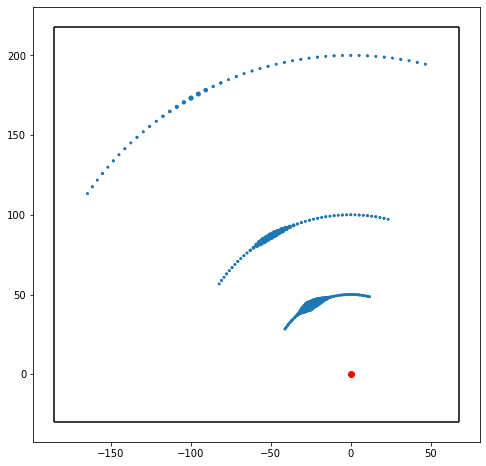

In [9]:
plt.figure(figsize=[8,8])
plt.scatter(X[:,2],X[:,3],3+Y/10)
plt.hlines([boundary[0][2],boundary[1][2]],boundary[0][1],boundary[1][1])
plt.vlines([boundary[0][1],boundary[1][1]],boundary[0][2],boundary[1][2])
plt.plot([0],[0],'or')
plt.axis('equal')

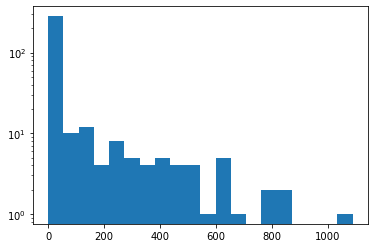

In [10]:
plt.hist(Y,20,log=True);

In [11]:
#Y /= np.std(Y)

In [12]:
rh.experiments[0].windX,rh.experiments[0].windY

(-0.9943022826340254, 1.8949836333722694)

In [13]:
np.max(Y)

1088.0

In [14]:
#set up our model...
N_feat = 1000 #Number of features used to infer the source
k = EQ(40, 100)
res = [100,30,30]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
assert gbs<6, "TOO BIG :("
noiseSD = 0.1
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference


Memory usage in grid model: 0.24 Gb


In [15]:
#maybe this is the sort of equivalent to the number of upcrossings in 3d?
#the number of fourier features is going to need to be of this order presumably?
np.prod(np.array(boundary[1])-np.array(boundary[0]))/(k.l2*np.pi)

360917.5743088082

In [16]:
mInfer.computeModelRegressors(Nparticles=5) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


In [17]:
scaleby = [5,2,2]
mInfer.coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]] #20x10x10
concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=6,Nparticles=5)

/home/mike/Documents/Research/advectionGP/advectionGP/mfmodels.py:70: RuntimeWarning: covariance is not positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


Initialising particles...
Diffusing particles...


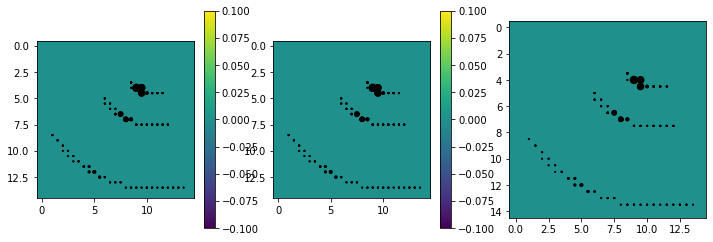

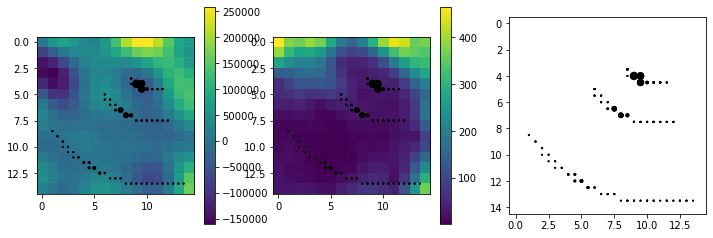

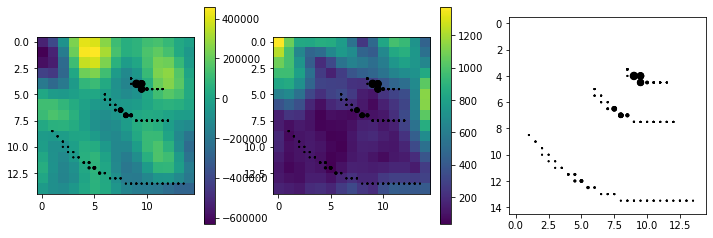

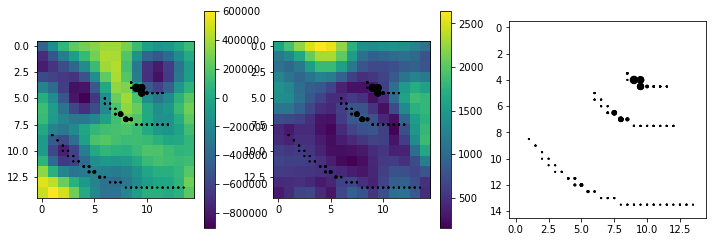

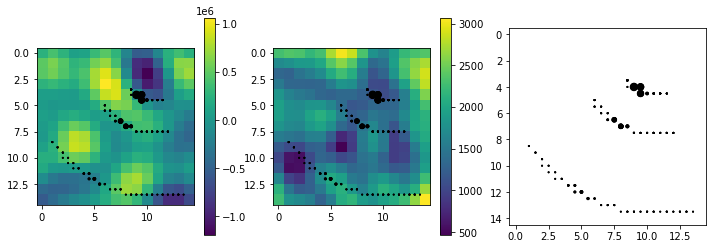

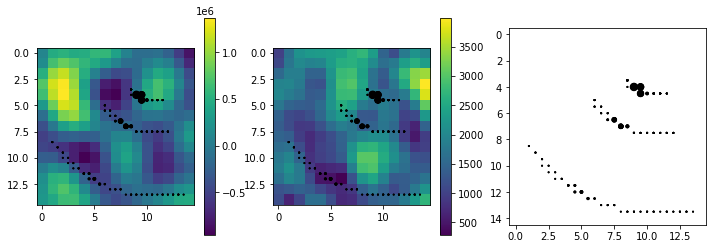

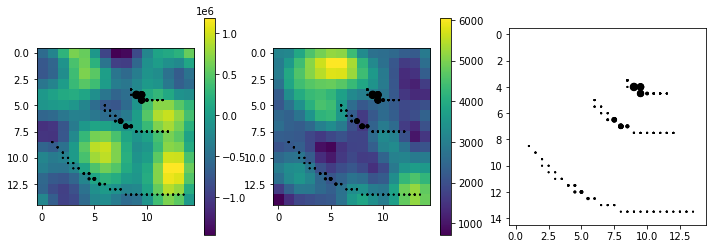

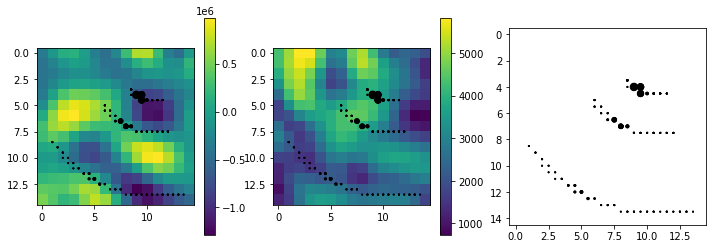

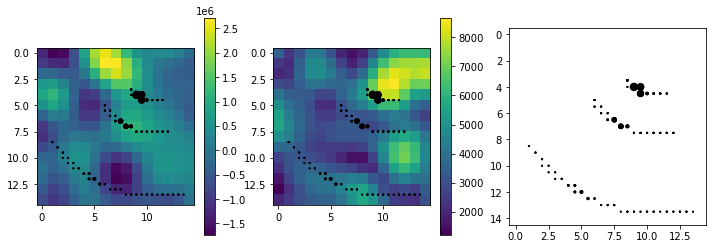

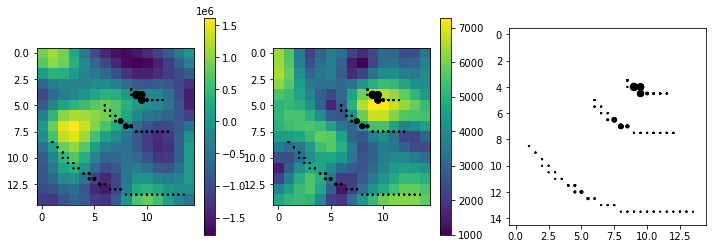

In [19]:
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby)

for tsamp in range(0,mInfer.coords.shape[1],2):
    plt.figure(figsize=[12,4])
    plt.title(tsamp)
    plt.subplot(1,3,1)
    plt.scatter(gridX[:,1],gridX[:,2],1+Y/20,color='black')
    plt.imshow(concmean[tsamp,:,:])
    #plt.clim([-5,5])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.scatter(gridX[:,1],gridX[:,2],1+Y/20,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    #plt.clim([0,5])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.scatter(gridX[:,1],gridX[:,2],1+Y/20,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<0.05
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-5,5])
    
    #plt.subplot(1,4,4)
    #plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    #plt.imshow(realconc[tsamp,:,:])    
    #plt.clim([-5,5])
    #plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #